In [112]:
import re
import pandas as pd
import datetime as dt


def read_kko_msg(filename):
    with open(filename, encoding='utf-8') as f:
        msg_list = f.readlines()

    return msg_list


def apply_kko_regex(msg_list):
    kko_pattern = re.compile("\[([\S\s]+)\] \[(오전|오후) ([0-9:\s]+)\] ([^\n]+)")
    kko_date_pattern = re.compile("--------------- ([0-9]+년 [0-9]+월 [0-9]+일) ")

    emoji_pattern = re.compile("["u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)

    kko_parse_result = list()
    cur_date = ""

    for msg in msg_list:
        # 날짜 부분인 경우
        if len(kko_date_pattern.findall(msg)) > 0:
            cur_date = dt.datetime.strptime(kko_date_pattern.findall(msg)[0], "%Y년 %m월 %d일")
            cur_date = cur_date.strftime("%Y-%m-%d")
        else:
            kko_pattern_result = kko_pattern.findall(msg)
            if len(kko_pattern_result) > 0:
                tokens = list(kko_pattern_result[0])
                # 이모지 데이터 삭제
                tokens[-1] = re.sub(emoji_pattern, "", tokens[-1])
                tokens.insert(0, cur_date)
                kko_parse_result.append(tokens)

    kko_parse_result = pd.DataFrame(kko_parse_result, columns=["Date", "Speaker", "timetype", "time", "contents"])
    kko_parse_result.to_csv("kko_regex.csv", index=False)

    return kko_parse_result


if __name__ == '__main__':
    msg_list = read_kko_msg("C://Users//user//Github/Project_Kakao chat/카톡대화.txt")
    apply_kko_regex(msg_list)

In [113]:
df = pd.read_csv("C://Users//user//Github/Project_Kakao chat/kko_regex.csv")

In [114]:
df.head()

,Date,Speaker,timetype,time,contents
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네
2,2017-01-19,김재민,오전,2:19,오
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ


# Data Preparation

In [115]:
df.Date = pd.to_datetime(df.Date)

In [116]:
df.dtypes

Date        datetime64[ns]
Speaker             object
timetype            object
time                object
contents            object
dtype: object

In [117]:
df["year"] = df['Date'].dt.strftime('%Y')
df["month"] = df['Date'].dt.strftime('%m')
df["day"] = df['Date'].dt.strftime('%d')
df["weekday"] = df['Date'].dt.weekday_name

df["24time"] = df["timetype"] + " " + df["time"]
df["24time"] = df["24time"].map(lambda x : x.replace("오전","AM"))
df["24time"] = df["24time"].map(lambda x : x.replace("오후","PM"))

In [118]:
temp = []
transform_time = []
for i in range(len(df)) :
    time = df["24time"][i]
    temp.append(dt.datetime.strptime(time,"%p %I:%M"))
    transform_time.append(temp[i].time())

df["24time"] = transform_time

In [119]:
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00


In [120]:
df.isnull().sum()

Date         0
Speaker      0
timetype     0
time         0
contents    46
year         0
month        0
day          0
weekday      0
24time       0
dtype: int64

In [121]:
df = df.fillna('null')

In [122]:
df.isnull().sum()

Date        0
Speaker     0
timetype    0
time        0
contents    0
year        0
month       0
day         0
weekday     0
24time      0
dtype: int64

In [123]:
title_len = []

for i in range(len(df)):
    ttl = len(df['contents'][i])
    title_len.append(ttl)

df['length'] = title_len
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,length
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,10
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,11
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,1
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,11
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,3


In [124]:
df.dtypes

Date        datetime64[ns]
Speaker             object
timetype            object
time                object
contents            object
year                object
month               object
day                 object
weekday             object
24time              object
length               int64
dtype: object

In [125]:
# 시간 분 설정
str_time = []
hh = []
mm = []
# bin_size = 15

for i in range(len(df)) :
    a = str(df["24time"][i])
    str_time.append(a.replace(":"," ").split(" "))
    
    h = str_time[i][0]
    m = str_time[i][1] ## //bin_size*bin_size # 두번 나누면 몫
    
    hh.append(h)
    mm.append(m)

df["hh"] = hh
df["mm"] = mm

%time

Wall time: 0 ns


In [126]:
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,length,hh,mm
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,10,02,16
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,11,02,16
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,1,02,19
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,11,02,19
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,3,02,19


In [127]:
quarter = []
# 계절 설정

for i in range(len(df)) :
    a = int(df["month"][i])
    if a >= 1 and a <= 3 :
        quarter.append("1q")
    if a >= 4 and a <= 6 :
        quarter.append("2q")
    if a >= 7 and a <= 9 :
        quarter.append("3q")
    if a >= 10 and a <= 12 :
        quarter.append("4q")

df["quarter"] = quarter

In [128]:
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,length,hh,mm,quarter
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,10,02,16,1q
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,11,02,16,1q
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,1,02,19,1q
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,11,02,19,1q
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,3,02,19,1q


# Visualization

['NanumGothic']


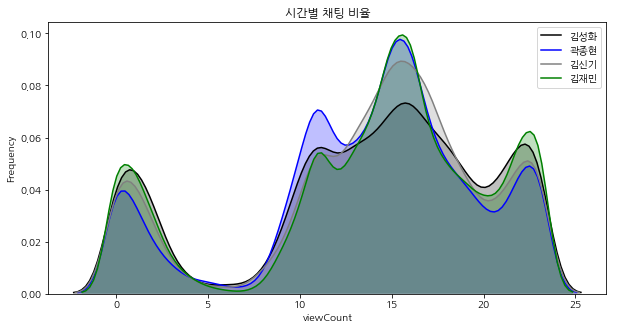

In [130]:
# 그래프 모듈 설치
import seaborn as sns

# 그래프 삽입 모듈 및 그래프 내 한글 폰트 삽입 코드
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
print(plt.rcParams['font.family'])

fig, ax = plt.subplots(figsize=(10,5))

g = sns.kdeplot(df['hh'][(df['Speaker'] == '김성화') & (df["hh"].notnull())], color="Black", shade = True)
g = sns.kdeplot(df['hh'][(df['Speaker'] == '곽종현🎗') & (df["hh"].notnull())], ax =g, color="Blue", shade= True)
g = sns.kdeplot(df['hh'][(df['Speaker'] == '김신기') & (df["hh"].notnull())], ax =g, color="Gray", shade= True)
g = sns.kdeplot(df['hh'][(df['Speaker'] == '김재민') & (df["hh"].notnull())], ax =g, color="Green", shade= True)

g.set_xlabel("viewCount")
g.set_ylabel("Frequency")
plt.title("시간별 채팅 비율")
g = g.legend(["김성화","곽종현","김신기","김재민"])

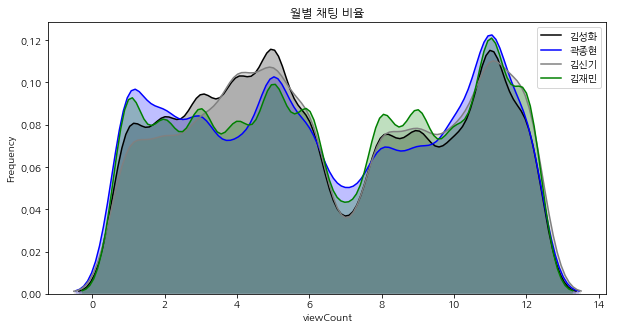

In [131]:
fig, ax = plt.subplots(figsize=(10,5))

g = sns.kdeplot(df['month'][(df['Speaker'] == '김성화') & (df["month"].notnull())], color="Black", shade = True)
g = sns.kdeplot(df['month'][(df['Speaker'] == '곽종현🎗') & (df["month"].notnull())], ax =g, color="Blue", shade= True)
g = sns.kdeplot(df['month'][(df['Speaker'] == '김신기') & (df["month"].notnull())], ax =g, color="Gray", shade= True)
g = sns.kdeplot(df['month'][(df['Speaker'] == '김재민') & (df["month"].notnull())], ax =g, color="Green", shade= True)

g.set_xlabel("viewCount")
g.set_ylabel("Frequency")
plt.title("월별 채팅 비율")
g = g.legend(["김성화","곽종현","김신기","김재민"],loc="best")

In [132]:
from collections import Counter
temp = Counter(df["24time"]).most_common(10000)
stime = sorted(temp, key = lambda x : x[0])
t, c = zip(*stime)

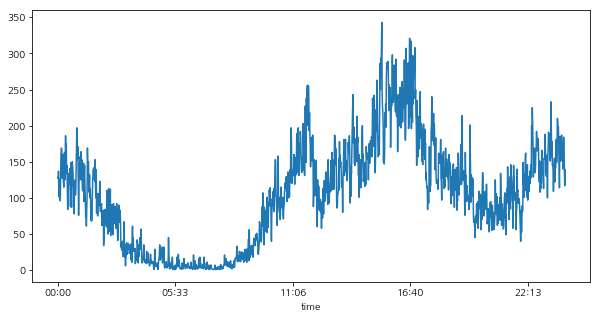

In [133]:
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
plt.plot_date(t,c,fmt='-') # fmt는 실선인지 점선인지 모양 구분
ax.xaxis.set_tick_params(labelsize = 10) #rotation = 30

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[1] = '00:00'
labels[2] = '05:33'
labels[3] = '11:06'
labels[4] = '16:40'
labels[5] = '22:13'

ax.set_xticklabels(labels)

plt.show()

In [134]:
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,length,hh,mm,quarter
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,10,02,16,1q
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,11,02,16,1q
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,1,02,19,1q
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,11,02,19,1q
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,3,02,19,1q


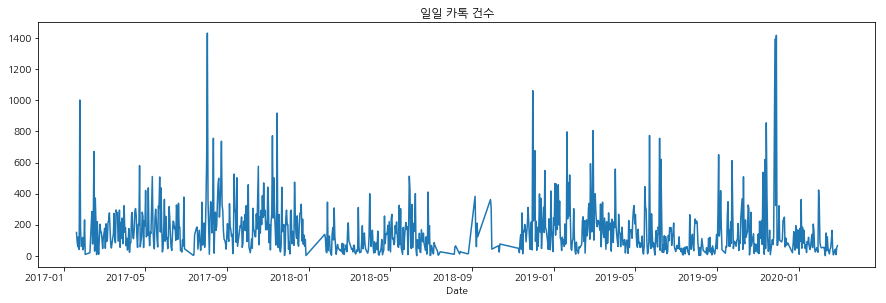

In [135]:
df.groupby('Date').count()['24time'].plot(kind='line', figsize=(15,5))
plt.title('일일 카톡 건수')
plt.xticks(rotation = 0)
plt.show()

In [ ]:
# 가장 많은 카톡을 한 상위 5일
df.groupby('Date').count()['24time']

In [136]:
df["Speaker"][df["Speaker"] == "곽종현🎗] [오후 7:49] [김성화" ] = "김성화"

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [137]:
df["Speaker"][df["Speaker"] == "곽종현🎗] [오전 11:18] [김신기" ] = "김신기"

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [138]:
df["Speaker"].value_counts()

김재민     56860
김성화     37108
곽종현🎗    31925
김신기     23315
Name: Speaker, dtype: int64

In [139]:
count_df = df.groupby('Speaker').count()['contents']

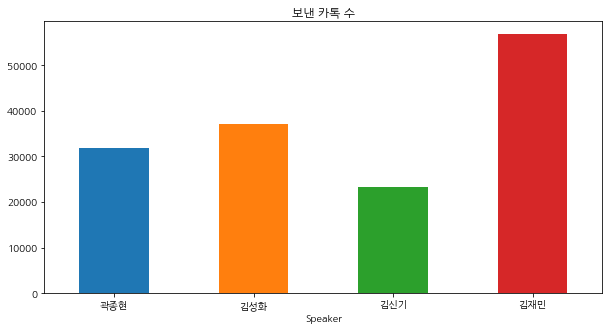

In [140]:
fig, ax = plt.subplots(figsize=(10,5))

count_df.plot(kind='bar')
plt.title('보낸 카톡 수')

ax.xaxis.set_tick_params(labelsize = 10, rotation=360) 

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = '곽종현'
labels[1] = '김성화'
labels[2] = '김신기'
labels[3] = '김재민'

ax.set_xticklabels(labels)


plt.show()

In [141]:
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,length,hh,mm,quarter
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,10,02,16,1q
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,11,02,16,1q
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,1,02,19,1q
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,11,02,19,1q
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,3,02,19,1q


In [142]:
date = []
time = []
for i in range(len(df)) :
    dd = str(df["Date"][i]).split(" 00:")[0]
    tt= str(df["24time"][i]).split(":00")[0]
    
    date.append(dd)
    time.append(tt)

In [143]:
d = pd.DataFrame(date)
t = pd.DataFrame(time)

In [144]:
df["Datetime"] = d + " " + t

In [145]:
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,length,hh,mm,quarter,Datetime
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,10,02,16,1q,2017-01-19 02:16
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,11,02,16,1q,2017-01-19 02:16
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,1,02,19,1q,2017-01-19 02:19
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,11,02,19,1q,2017-01-19 02:19
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,3,02,19,1q,2017-01-19 02:19


In [146]:
df.Datetime = pd.to_datetime(df.Datetime)

In [147]:
df['delta'] = (df['Datetime'].shift(-1)-df['Datetime']).fillna(0)
df['is_indifferent'] = ((df['Speaker'] != df['Speaker'].shift(-1)) & ((df['delta'].dt.seconds//60 >= 10)&(df['delta'].dt.seconds//60 <= 30)))

In [148]:
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,length,hh,mm,quarter,Datetime,delta,is_indifferent
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,10,02,16,1q,2017-01-19 02:16:00,00:00:00,False
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,11,02,16,1q,2017-01-19 02:16:00,00:03:00,False
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,1,02,19,1q,2017-01-19 02:19:00,00:00:00,False
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,11,02,19,1q,2017-01-19 02:19:00,00:00:00,False
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,3,02,19,1q,2017-01-19 02:19:00,00:02:00,False


In [149]:
df["is_indifferent"].value_counts()

False    145028
True       4180
Name: is_indifferent, dtype: int64

In [150]:
df[df['is_indifferent']==True].groupby('Speaker').count()['contents']

Speaker
곽종현🎗     745
김성화     1168
김신기      911
김재민     1356
Name: contents, dtype: int64

In [151]:
ice_age = pd.DataFrame(df[df['is_indifferent']==True].groupby('Speaker').count()['contents'])
ice_age.index.name = ""
ice_age.columns.name = ''

In [152]:
ice_age

,contents
,
곽종현🎗,745
김성화,1168
김신기,911
김재민,1356


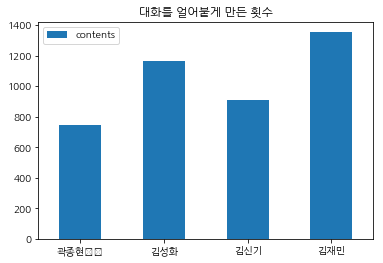

In [153]:
ice_age.plot(kind='bar')
plt.title('대화를 얼어붙게 만든 횟수')
plt.tick_params(rotation=360)
plt.show()

In [154]:
# 가장 영양가 있는 대화를 하는 사람 - 대화를 얼어붙게 만든 비율 / 전체 카톡 중 채팅 비율
ice_age

,contents
,
곽종현🎗,745
김성화,1168
김신기,911
김재민,1356


In [155]:
ice_rate_sh = ice_age["contents"]["김성화"]/ice_age["contents"].sum()
ice_rate_jh = ice_age["contents"]["곽종현🎗"]/ice_age["contents"].sum()
ice_rate_sg = ice_age["contents"]["김신기"]/ice_age["contents"].sum()
ice_rate_jm = ice_age["contents"]["김재민"]/ice_age["contents"].sum()

In [156]:
count_df = pd.DataFrame(count_df)
count_df.index.name = ""
count_df.columns.name = ''
count_df

,contents
,
곽종현🎗,31925
김성화,37108
김신기,23315
김재민,56860


In [157]:
chat_rate_sh = count_df["contents"]["김성화"]/count_df["contents"].sum()
chat_rate_jh = count_df["contents"]["곽종현🎗"]/count_df["contents"].sum()
chat_rate_sg = count_df["contents"]["김신기"]/count_df["contents"].sum()
chat_rate_jm = count_df["contents"]["김재민"]/count_df["contents"].sum()

In [158]:
# ice_rate
ice_rate_SH = round(ice_rate_sh/chat_rate_sh,2)*100
ice_rate_JH = round(ice_rate_jh/chat_rate_jh,2)*100
ice_rate_SG = round(ice_rate_sg/chat_rate_sg,2)*100
ice_rate_JM = round(ice_rate_jm/chat_rate_jm,2)*100

In [159]:
ice_rate = pd.DataFrame(data=[ice_rate_SH,ice_rate_JH,ice_rate_SG,ice_rate_JM], index=["SH","JH","SG","JM"], columns=['ice_age_index'])
display(pd.DataFrame(ice_rate))

,ice_age_index
SH,112.0
JH,83.0
SG,139.0
JM,85.0


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

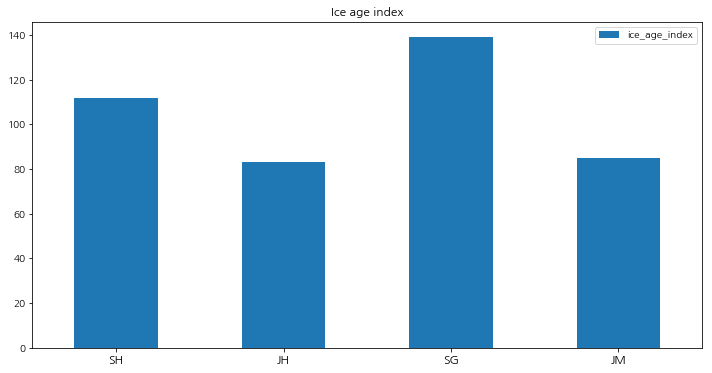

In [160]:
ice_rate.plot(kind='bar', figsize=(12,6))
plt.title("Ice age index")
plt.xticks(rotation=360,fontsize = 12)

In [161]:
# 19년 6월 부터 나누기 라이프스타일 변화
df1 = df[:117423]
len(df1)

117423

In [162]:
df2 = df[117423:149206]
len(df2)

31783

In [163]:
# 일별 대화량
Daliy_chat_df1 = len(df1) / len(df1["Date"].drop_duplicates())
Daliy_chat_df2 = len(df2) / len(df2["Date"].drop_duplicates())

print("라이프스타일 변화 전 : 일별평균", round(Daliy_chat_df1,1),"개", 
      "\n라이프스타일 변화 후 : 일별평균", round(Daliy_chat_df2,1), "개")

라이프스타일 변화 전 : 일별평균 167.7 개 
라이프스타일 변화 후 : 일별평균 130.3 개


In [164]:
df1.groupby('Speaker').count()['contents']

Speaker
곽종현🎗    23422
김성화     30771
김신기     19093
김재민     44137
Name: contents, dtype: int64

In [165]:
total_before = df1.groupby('Speaker').count()['contents'].sum()
chat_before = pd.DataFrame(df1.groupby('Speaker').count()['contents'])
chat_before

,contents
Speaker,
곽종현🎗,23422
김성화,30771
김신기,19093
김재민,44137


In [166]:
before_sh = chat_before[chat_before.index == "김성화"]["contents"][0]
before_jh = chat_before[chat_before.index == "곽종현🎗"]["contents"][0]
before_sg = chat_before[chat_before.index == "김신기"]["contents"][0]
before_jm = chat_before[chat_before.index == "김재민"]["contents"][0]

before = [before_sh,before_jh,before_sg,before_jm]
before_name = ["김성화","곽종현","김신기","김재민"]

import numpy as np
np.array(before)
np.array(before_name)

array(['김성화', '곽종현', '김신기', '김재민'], dtype='<U3')

<BarContainer object of 4 artists>

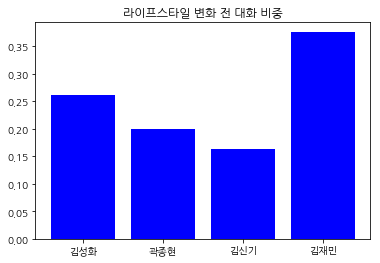

In [167]:
plt.figure(figsize=(6,4)) 
plt.title("라이프스타일 변화 전 대화 비중") 

plt.bar(np.array(before_name), np.array(before)/total_before, color='Blue')

In [168]:
df2.groupby('Speaker').count()['contents']

Speaker
곽종현🎗     8503
김성화      6335
김신기      4222
김재민     12723
Name: contents, dtype: int64

In [169]:
total_after = df2.groupby('Speaker').count()['contents'].sum()
chat_after = pd.DataFrame(df2.groupby('Speaker').count()['contents'])
chat_after

,contents
Speaker,
곽종현🎗,8503
김성화,6335
김신기,4222
김재민,12723


In [170]:
after_sh = chat_after[chat_after.index == "김성화"]["contents"][0]
after_jh = chat_after[chat_after.index == "곽종현🎗"]["contents"][0]
after_sg = chat_after[chat_after.index == "김신기"]["contents"][0]
after_jm = chat_after[chat_after.index == "김재민"]["contents"][0]

after = [after_sh, after_jh, after_sg, after_jm]
after_name = ["김성화","곽종현","김신기","김재민"]

import numpy as np
np.array(after)
np.array(after_name)

array(['김성화', '곽종현', '김신기', '김재민'], dtype='<U3')

<BarContainer object of 4 artists>

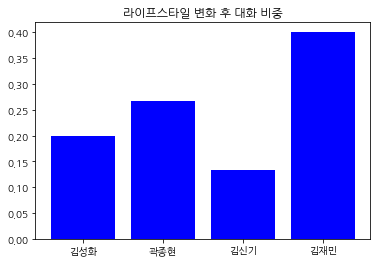

In [171]:
plt.figure(figsize=(6,4)) 
plt.title("라이프스타일 변화 후 대화 비중") 

plt.bar(np.array(after_name), np.array(after)/total_after, color='Blue')

In [172]:
# 평균 대화 길이 흡사 설명층
df.groupby("Speaker").sum()["length"]/df1.groupby("Speaker").count()["length"]

Speaker
곽종현🎗    10.575357
김성화     11.067986
김신기     11.962552
김재민      9.270703
Name: length, dtype: float64

In [173]:
long_tongue = pd.DataFrame([10.6, 11.1, 12, 9.3],["곽종현", "김성화", "김신기", "김재민"],columns=["length"])

In [174]:
long_tongue

,length
곽종현,10.6
김성화,11.1
김신기,12.0
김재민,9.3


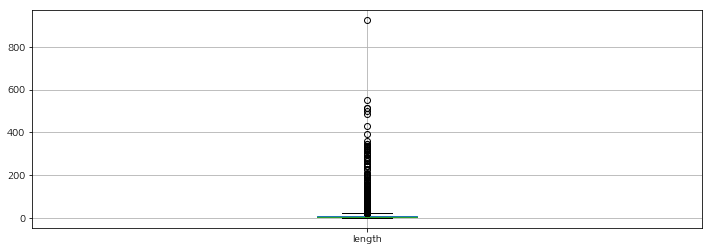

In [175]:
plt.figure(figsize=(12,4))
df.boxplot(column="length")

In [176]:
def removeOutliers(x, column):
    # Q1, Q3구하기
    q1 = x[column].quantile(0.25)
    q3 = x[column].quantile(0.75)
    
    # 1.5 * IQR(Q3 - Q1)
    iqt = 1.5 * (q3 - q1)
    
    # 원래 데이터 복제
    y = x
    
    # 이상치를 NA로 변환
    outlier = y["length"][(df["length"] > (q3 + iqt)) | (df["length"] < (q1 - iqt))]
    
    # y 반환
    return(outlier)

In [177]:
outlier_index = removeOutliers(df,"length").index

In [178]:
outlier = df.loc[outlier_index]

In [179]:
outlier.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,length,hh,mm,quarter,Datetime,delta,is_indifferent
12,2017-01-19,김성화,오전,2:28,ㅋㅋㅋ그런애들 아빠가 콤마 틀라이언트 계약해주실수도있다,2017,01,19,Thursday,02:28:00,30,02,28,1q,2017-01-19 02:28:00,00:01:00,False
23,2017-01-19,김신기,오전,11:28,재민아 토트넘 경기 어떤 사이트 통해서 예매햇냐,2017,01,19,Thursday,11:28:00,26,11,28,1q,2017-01-19 11:28:00,01:45:00,False
30,2017-01-19,김신기,오후,2:25,유럽축구 예매 좋은 사이트 혹시 아나해서 물어보려고햇지,2017,01,19,Thursday,14:25:00,30,14,25,1q,2017-01-19 14:25:00,00:00:00,False
34,2017-01-19,김신기,오후,2:33,통합적으로 관리하는 사이트 혹시 아나해서 그랫징,2017,01,19,Thursday,14:33:00,26,14,33,1q,2017-01-19 14:33:00,00:00:00,False
275,2017-01-21,곽종현🎗,오전,10:26,솔직히 너도나도 갔다고 생각했는데 막상 간다는건 힘들고 간애들 얘기만 들어서 그렇지...,2017,01,21,Saturday,10:26:00,61,10,26,1q,2017-01-21 10:26:00,00:02:00,False


In [180]:
outlier.groupby("Speaker").count()["contents"]

Speaker
곽종현🎗    1058
김성화     1230
김신기     1030
김재민     1100
Name: contents, dtype: int64

In [181]:
outlier.groupby("Speaker").sum()["length"]

Speaker
곽종현🎗    44185
김성화     43207
김신기     38971
김재민     47635
Name: length, dtype: int64

In [182]:
outlier.groupby("Speaker").sum()["length"] / outlier.groupby("Speaker").count()["contents"]

Speaker
곽종현🎗    41.762760
김성화     35.127642
김신기     37.835922
김재민     43.304545
dtype: float64

# Topic modeling

In [183]:
# 데이터 전처리
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자,자음 제거
    text = re.sub('[.,;:\)*?!~`’^\-_+<>@\#$%&=#}※ㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㅠㅜ]', '', text)
    # 중복 생성 공백값
    text = re.sub(' +', ' ', text)
    return text


# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['ㅎㅎㅎ','ㅎㅎ','ㅋㅋ','ㅋ','ㅎㅎ','ㅎ','ㅋㅋㅋ','ㅋㅋ','ㅠㅠㅠㅠ','ㅠㅠ',"신기","성화",'재민','종현'
            "그냥","거기","지금","이제","우리","일단","한번","나도","하는","그게","약간","그거","해서","재미","뭔가","이모티콘"
            "존나", "누가", "하기", "하는데", "거의", "할게", "이번", "이건", "사실", "정도", "갑자기", "혹시", "보고","하노"]
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [184]:
df['new'] = df['contents'].apply(preprocessing)
df['nnew'] = df['new'].apply(remove_stopwords)

In [185]:
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,length,hh,mm,quarter,Datetime,delta,is_indifferent,new,nnew
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,10,02,16,1q,2017-01-19 02:16:00,00:00:00,False,오 팁 이만냥 받음,오 팁 이만냥 받음
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,11,02,16,1q,2017-01-19 02:16:00,00:03:00,False,재민 그동네 좀 좋네,그동네 좀 좋네
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,1,02,19,1q,2017-01-19 02:19:00,00:00:00,False,오,오
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,11,02,19,1q,2017-01-19 02:19:00,00:00:00,False,난 카지노 3만원잃음,난 카지노 3만원잃음
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,3,02,19,1q,2017-01-19 02:19:00,00:02:00,False,,


In [108]:
!pip install konlpy

In [187]:
# from konlpy.tag import Mecab
from konlpy.tag import Okt
import time

In [188]:
start = time.time()
okt = Okt()

nouns = []
morphs = []
pos = []

for i in range(len(df)):
    no = okt.nouns(str(df['nnew'][i]))
    mo = okt.morphs(str(df['nnew'][i]))
    po = okt.pos(str(df['nnew'][i]))
    nouns.append(no)
    morphs.append(mo)
    pos.append(po)

df['nouns'] = nouns
df['morphs'] = morphs
df['pos'] = pos

%time

Wall time: 0 ns


In [189]:
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,...,mm,quarter,Datetime,delta,is_indifferent,new,nnew,nouns,morphs,pos
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,...,16,1q,2017-01-19 02:16:00,00:00:00,False,오 팁 이만냥 받음,오 팁 이만냥 받음,"[오, 팁, 이만]","[오, 팁, 이만, 냥, 받음]","[(오, Noun), (팁, Noun), (이만, Noun), (냥, Josa), ..."
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,...,16,1q,2017-01-19 02:16:00,00:03:00,False,재민 그동네 좀 좋네,그동네 좀 좋네,"[동네, 좀]","[그, 동네, 좀, 좋네]","[(그, Determiner), (동네, Noun), (좀, Noun), (좋네, ..."
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,...,19,1q,2017-01-19 02:19:00,00:00:00,False,오,오,[오],[오],"[(오, Noun)]"
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,...,19,1q,2017-01-19 02:19:00,00:00:00,False,난 카지노 3만원잃음,난 카지노 3만원잃음,"[난, 카지노]","[난, 카지노, 3만원, 잃음]","[(난, Noun), (카지노, Noun), (3만원, Number), (잃음, F..."
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,...,19,1q,2017-01-19 02:19:00,00:02:00,False,,,[],[],[]


In [190]:
verbs1 = df['pos']
dict_verb = []

for i in range(len(verbs1)):
    vb = dict(verbs1[i])
    dict_verb.append(vb)

df['dic_verb'] = dict_verb
df

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,...,quarter,Datetime,delta,is_indifferent,new,nnew,nouns,morphs,pos,dic_verb
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,...,1q,2017-01-19 02:16:00,00:00:00,False,오 팁 이만냥 받음,오 팁 이만냥 받음,"[오, 팁, 이만]","[오, 팁, 이만, 냥, 받음]","[(오, Noun), (팁, Noun), (이만, Noun), (냥, Josa), ...","{'오': 'Noun', '팁': 'Noun', '이만': 'Noun', '냥': ..."
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,...,1q,2017-01-19 02:16:00,00:03:00,False,재민 그동네 좀 좋네,그동네 좀 좋네,"[동네, 좀]","[그, 동네, 좀, 좋네]","[(그, Determiner), (동네, Noun), (좀, Noun), (좋네, ...","{'그': 'Determiner', '동네': 'Noun', '좀': 'Noun',..."
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,...,1q,2017-01-19 02:19:00,00:00:00,False,오,오,[오],[오],"[(오, Noun)]",{'오': 'Noun'}
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,...,1q,2017-01-19 02:19:00,00:00:00,False,난 카지노 3만원잃음,난 카지노 3만원잃음,"[난, 카지노]","[난, 카지노, 3만원, 잃음]","[(난, Noun), (카지노, Noun), (3만원, Number), (잃음, F...","{'난': 'Noun', '카지노': 'Noun', '3만원': 'Number', ..."
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,...,1q,2017-01-19 02:19:00,00:02:00,False,,,[],[],[],{}
5,2017-01-19,김성화,오전,2:21,ㅋㅋ븅신,2017,01,19,Thursday,02:21:00,...,1q,2017-01-19 02:21:00,00:00:00,False,븅신,븅신,[븅신],[븅신],"[(븅신, Noun)]",{'븅신': 'Noun'}
6,2017-01-19,김재민,오전,2:21,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,2017,01,19,Thursday,02:21:00,...,1q,2017-01-19 02:21:00,00:00:00,False,,,[],[],[],{}
7,2017-01-19,김재민,오전,2:21,여기 한심하게돈많은놈들많더,2017,01,19,Thursday,02:21:00,...,1q,2017-01-19 02:21:00,00:00:00,False,여기 한심하게돈많은놈들많더,여기 한심하게돈많은놈들많더,"[여기, 돈, 놈]","[여기, 한심하게, 돈, 많은, 놈, 들, 많더]","[(여기, Noun), (한심하게, Adjective), (돈, Noun), (많은...","{'여기': 'Noun', '한심하게': 'Adjective', '돈': 'Noun..."
8,2017-01-19,김재민,오전,2:21,개부럽,2017,01,19,Thursday,02:21:00,...,1q,2017-01-19 02:21:00,00:01:00,False,개부럽,개부럽,[개],"[개, 부럽]","[(개, Noun), (부럽, Adjective)]","{'개': 'Noun', '부럽': 'Adjective'}"
9,2017-01-19,김성화,오전,2:22,ㅋㅋㅋ그새끼들 연락처받아놔라,2017,01,19,Thursday,02:22:00,...,1q,2017-01-19 02:22:00,00:04:00,False,그새끼들 연락처받아놔라,그새끼들 연락처받아놔라,"[새끼, 연락처]","[그, 새끼, 들, 연락처, 받아, 놔라]","[(그, Determiner), (새끼, Noun), (들, Suffix), (연락...","{'그': 'Determiner', '새끼': 'Noun', '들': 'Suffix..."


In [191]:
verb_2 = []

for i in range(len(dict_verb)):
    verb_3 = [str(key) for (key, value) in dict_verb[i].items() if value == 'Verb']
    verb_2.append(verb_3)

df['verb'] =verb_2 

In [192]:
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,...,Datetime,delta,is_indifferent,new,nnew,nouns,morphs,pos,dic_verb,verb
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,...,2017-01-19 02:16:00,00:00:00,False,오 팁 이만냥 받음,오 팁 이만냥 받음,"[오, 팁, 이만]","[오, 팁, 이만, 냥, 받음]","[(오, Noun), (팁, Noun), (이만, Noun), (냥, Josa), ...","{'오': 'Noun', '팁': 'Noun', '이만': 'Noun', '냥': ...",[받음]
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,...,2017-01-19 02:16:00,00:03:00,False,재민 그동네 좀 좋네,그동네 좀 좋네,"[동네, 좀]","[그, 동네, 좀, 좋네]","[(그, Determiner), (동네, Noun), (좀, Noun), (좋네, ...","{'그': 'Determiner', '동네': 'Noun', '좀': 'Noun',...",[]
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,...,2017-01-19 02:19:00,00:00:00,False,오,오,[오],[오],"[(오, Noun)]",{'오': 'Noun'},[]
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,...,2017-01-19 02:19:00,00:00:00,False,난 카지노 3만원잃음,난 카지노 3만원잃음,"[난, 카지노]","[난, 카지노, 3만원, 잃음]","[(난, Noun), (카지노, Noun), (3만원, Number), (잃음, F...","{'난': 'Noun', '카지노': 'Noun', '3만원': 'Number', ...",[]
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,...,2017-01-19 02:19:00,00:02:00,False,,,[],[],[],{},[]


In [193]:
df['sentence'] = df['nouns'] + df['verb']
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,...,delta,is_indifferent,new,nnew,nouns,morphs,pos,dic_verb,verb,sentence
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,...,00:00:00,False,오 팁 이만냥 받음,오 팁 이만냥 받음,"[오, 팁, 이만]","[오, 팁, 이만, 냥, 받음]","[(오, Noun), (팁, Noun), (이만, Noun), (냥, Josa), ...","{'오': 'Noun', '팁': 'Noun', '이만': 'Noun', '냥': ...",[받음],"[오, 팁, 이만, 받음]"
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,...,00:03:00,False,재민 그동네 좀 좋네,그동네 좀 좋네,"[동네, 좀]","[그, 동네, 좀, 좋네]","[(그, Determiner), (동네, Noun), (좀, Noun), (좋네, ...","{'그': 'Determiner', '동네': 'Noun', '좀': 'Noun',...",[],"[동네, 좀]"
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,...,00:00:00,False,오,오,[오],[오],"[(오, Noun)]",{'오': 'Noun'},[],[오]
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,...,00:00:00,False,난 카지노 3만원잃음,난 카지노 3만원잃음,"[난, 카지노]","[난, 카지노, 3만원, 잃음]","[(난, Noun), (카지노, Noun), (3만원, Number), (잃음, F...","{'난': 'Noun', '카지노': 'Noun', '3만원': 'Number', ...",[],"[난, 카지노]"
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,...,00:02:00,False,,,[],[],[],{},[],[]


In [194]:
tokenized_doc = df['sentence']
detokenized_doc = []

for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
df['headline_text'] = detokenized_doc
# 다시 text['headline_text'] 에 저장
df.head()

,Date,Speaker,timetype,time,contents,year,month,day,weekday,24time,...,is_indifferent,new,nnew,nouns,morphs,pos,dic_verb,verb,sentence,headline_text
0,2017-01-19,김성화,오전,2:16,오 팁 이만냥 받음,2017,01,19,Thursday,02:16:00,...,False,오 팁 이만냥 받음,오 팁 이만냥 받음,"[오, 팁, 이만]","[오, 팁, 이만, 냥, 받음]","[(오, Noun), (팁, Noun), (이만, Noun), (냥, Josa), ...","{'오': 'Noun', '팁': 'Noun', '이만': 'Noun', '냥': ...",[받음],"[오, 팁, 이만, 받음]",오 팁 이만 받음
1,2017-01-19,김성화,오전,2:16,재민 그동네 좀 좋네,2017,01,19,Thursday,02:16:00,...,False,재민 그동네 좀 좋네,그동네 좀 좋네,"[동네, 좀]","[그, 동네, 좀, 좋네]","[(그, Determiner), (동네, Noun), (좀, Noun), (좋네, ...","{'그': 'Determiner', '동네': 'Noun', '좀': 'Noun',...",[],"[동네, 좀]",동네 좀
2,2017-01-19,김재민,오전,2:19,오,2017,01,19,Thursday,02:19:00,...,False,오,오,[오],[오],"[(오, Noun)]",{'오': 'Noun'},[],[오],오
3,2017-01-19,김재민,오전,2:19,난 카지노 3만원잃음,2017,01,19,Thursday,02:19:00,...,False,난 카지노 3만원잃음,난 카지노 3만원잃음,"[난, 카지노]","[난, 카지노, 3만원, 잃음]","[(난, Noun), (카지노, Noun), (3만원, Number), (잃음, F...","{'난': 'Noun', '카지노': 'Noun', '3만원': 'Number', ...",[],"[난, 카지노]",난 카지노
4,2017-01-19,김재민,오전,2:19,ㅋㅋㅋ,2017,01,19,Thursday,02:19:00,...,False,,,[],[],[],{},[],[],


In [195]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=1000)
X = vectorizer.fit_transform(df['headline_text'])
X.shape

(149208, 1000)

In [196]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=777, max_iter=1)
lda_top = lda_model.fit_transform(X)

In [199]:
terms = vectorizer.get_feature_names() 
# 단어 집합. 1,000개의 단어가 저장되어있음.
df = []
def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        df.append([(feature_names[i]) for i in topic.argsort()[:-n -1:-1]])
get_topics(lda_model.components_, terms)

In [200]:
df = pd.DataFrame(df)
df.columns = ['topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8'
              ,'topic9','topic10']
df.reset_index(drop=True)

,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10
0,이노,추천,미안,소리,운동,학원,여자,영어,먹고,머리
1,카페,거기,주식,고생,할게,해라,보고,보면,출근,아침
2,하노,사람,하나,시간,느낌,경찰,한번,렁화,리얼,여행
3,종현,친구,우리,무슨,처음,자기,는데,봐라,이제,하루
4,진짜,여기,혜원,원래,대구,얼마,방금,인스타,해야,때문
5,이모티콘,요즘,누구,하자,노래,한국,지금,이름,들어,하는거
6,사진,검색,머민,공부,요미,되나,교수,전화,봤는데,병원
7,오늘,하는,해서,정도,신세,학교,저녁,이번,문제,시작
8,신기,이야기,어디,바로,하고,성화,내일,해도,다시,언제
9,그냥,생각,하면,어제,재민,한다,했다,했는데,요요,그때
